# 5. Collaborative Filtering - k-NN

In [1]:
import pandas as pd
import scipy as sp
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors


In [2]:
%run "01.Recommendation_Loading.ipynb"

################  Recommendations (all data, positive recommendations only) ################
Users: 12,636,209
Games: 37,419
Number of users 2,000
First five users id [11203022 12827342 11719330  9553563 11051045]
################  Recommendations (Sample) ################
Minimum number of recommendations to be included in the sample: 20
Number of randomly selected users: 2000
Users: 1,991
Games: 11,108
################ User-Game Matrix ################
Number of Rows: 1,992
Numbeer of Columns: 11,109
Number of stored values: 75,831


In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## Training and Test Istances

In [4]:
%run "Get_Training_and_Test_Instances.ipynb"

################  Get Test Data ################
x_test.shape: (1991, 2)
y_test.shape: (1991, 1)
Number of Users: 1,992
Number of Games: 11,109
Number of Negatives Sample per User-Game: 2
################  Get Training Data ################
x_train.shape: (226553, 2)
y_train.shape: (226553, 2)


In [5]:
x_test

array([[    0, 10918],
       [    1,  9556],
       [    2, 10978],
       ...,
       [ 1988,  8424],
       [ 1989, 10918],
       [ 1990, 10648]])

In [6]:
x_train.shape

(226553, 2)

Removing the test items from the user game matrix which will be used for training

In [7]:
# Check how many stored values before
user_game_matrix

<1992x11109 sparse matrix of type '<class 'numpy.int8'>'
	with 75831 stored elements in Dictionary Of Keys format>

In [8]:
# user_game_matrix_train = user_game_matrix.tocsc().astype("float32")
# user_game_matrix_train

In [9]:
for user_item in x_test:
    # user_game_matrix_train[user_item[0], user_item[1]] = np.NaN
    # user_game_matrix_k_rec_values = user_game_matrix_k_rec_values.astype('int8')
    user_game_matrix.pop((user_item[0], user_item[1]))


In [10]:
# Check how many stored values after
user_game_matrix

<1992x11109 sparse matrix of type '<class 'numpy.int8'>'
	with 73840 stored elements in Dictionary Of Keys format>

## Cosine Similarity and kNN Model

In [11]:
similarities = cosine_similarity(user_game_matrix)

In [12]:
similarities.shape

(1992, 1992)

In [13]:
def knn_model(similarity_matrix, K, metric):
    knn_model = NearestNeighbors(n_neighbors=K, metric=metric)
    knn_model.fit(similarity_matrix)
    # Create an empty table to store the nearest neighbors' indices and distances for all users
    neighbor_table = []
    
    # Iterate over each user in the similarity matrix
    for user_index in range(similarity_matrix.shape[0]-1):
        # Query the nearest neighbors for the current user
        query_user = similarity_matrix[user_index].reshape(1, -1)  # Reshape to match the input format
        distances, neighbor_indices = knn_model.kneighbors(query_user, K)
        
        # Append the user's nearest neighbors' indices and distances to the table
        neighbor_table.append({"User": user_index, "Nearest Neighbors": neighbor_indices[0], "Distances": distances[0]})

    # Convert the table to a pandas DataFrame for easier visualization
    neighbor_table_df = pd.DataFrame(neighbor_table)
    return neighbor_table_df

# Kn = 2
# neighbor_table_df = knn_model(similarities, Kn, 'cosine')


In [14]:
# neighbor_table_df.tail()

In [15]:
# neighbor_table_df_explode = neighbor_table_df[neighbor_table_df["User"]==96].explode(["Nearest Neighbors","Distances"])

## Model Evaluation

In [16]:
def eval_k_kNN(userid1, userid2, relevant_items, x_train, y_train, x_test):
    user_items1 = get_y_true(userid1, x_train, y_train)
    user_items1_test = x_test[userid1][1]
    user_items2 = get_y_true(userid2, x_train, y_train)
    intersection = set(user_items1).intersection(set(user_items2))
    prec = len(intersection) / relevant_items
    precision = prec if prec <= 1 else 1 
    recall = len(intersection) / len(set(user_items1))
    hgr = 1 if user_items1_test in user_items2 else 0
    return precision, recall, hgr
    

In [17]:
x_test

array([[    0, 10918],
       [    1,  9556],
       [    2, 10978],
       ...,
       [ 1988,  8424],
       [ 1989, 10918],
       [ 1990, 10648]])

In [18]:
eval_k_kNN(0, 997, 10, x_train, y_train, x_test)

(0.1, 0.03125, 0)

In [19]:
def avg_recall(row):
    user_id_current = row["User"]
    # print(user_id_current)
    precision_current = []
    recall_current = []
    hgr_current = []
    for i, neigh in enumerate(row["Nearest Neighbors"]):
        # print(i)
        # The computation should not be done for the same user
        if i>0:
            prec, recl, hgr = eval_k_kNN(user_id_current, neigh, 10, x_train, y_train, x_test)
            precision_current.append(prec)
            recall_current.append(recl)
            hgr_current.append(hgr)
    row["avg_precision"] = np.mean(precision_current)
    row["avg_recall"] = np.mean(recall_current)
    row["avg_hgr"] = np.mean(hgr_current)
    return row


In [20]:
# neighbor_table_df["avg_precision"] = np.NaN
# neighbor_table_df["avg_recall"] = np.NaN

In [21]:
# neighbor_table_df_acc = neighbor_table_df.apply(avg_recall, axis=1)
# neighbor_table_df_acc.head()

In [22]:
def accuracy_model(df):
    avg_prec_model = np.mean(df["avg_precision"])
    avg_recall_model = np.mean(df["avg_recall"])
    avg_hgr = np.mean(df["avg_hgr"])
    return avg_prec_model, avg_recall_model, avg_hgr

# accuracy_model(neighbor_table_df_acc)

In [38]:
precision_model = []
recall_model = []
hgr_model = []
num_neighbours = 11

for k in range(2,num_neighbours):
    print("############ K =", k, " ####################")
    neighbor_table_df = knn_model(similarities, k, "cosine")
    neighbor_table_df_acc = neighbor_table_df.apply(avg_recall, axis=1)
    prec, rec, hgr = accuracy_model(neighbor_table_df_acc)
    precision_model.append(prec)
    recall_model.append(rec)
    hgr_model.append(hgr)
 

############ K = 2  ####################
############ K = 3  ####################
############ K = 4  ####################
############ K = 5  ####################
############ K = 6  ####################
############ K = 7  ####################
############ K = 8  ####################
############ K = 9  ####################
############ K = 10  ####################


In [39]:
precision_model

[0.6709693621295832,
 0.6553741838272223,
 0.6406161058094763,
 0.6290055248618784,
 0.619337016574585,
 0.6095345722417543,
 0.6010619215039106,
 0.5938159216474134,
 0.5866789441375072]

In [40]:
recall_model

[0.22649739743703834,
 0.21837685126889247,
 0.2115423083236383,
 0.20637772936783969,
 0.20227999381823786,
 0.1982046781911863,
 0.19476489580959194,
 0.19181463267003152,
 0.18902243936322718]

In [41]:
hgr_model

[0.05474635861376193,
 0.05851330989452536,
 0.05508119872760741,
 0.05487192365645404,
 0.05384229030637897,
 0.05282102795914962,
 0.05280906938365498,
 0.05210949271722752,
 0.05134215078966503]

In [42]:
neighb = range(2,num_neighbours)

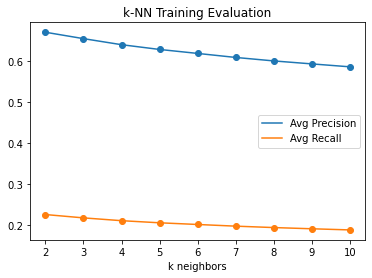

In [55]:
plt.plot(neighb, precision_model, label="Avg Precision")
plt.scatter(neighb, precision_model)
plt.plot(neighb, recall_model, label='Avg Recall')
plt.scatter(neighb, recall_model)
plt.title("k-NN Training Evaluation")
plt.xlabel("k neighbors")
plt.legend()
plt.show()


In [29]:
# plt.plot(neighb, recall_model, label='Avg Recall (Training Set)')
# plt.legend()
# plt.show()

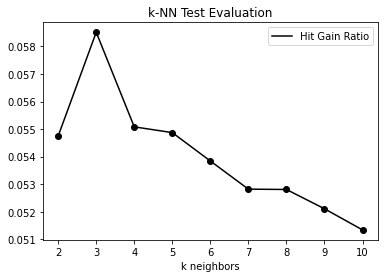

In [54]:
plt.plot(neighb, hgr_model, label="Hit Gain Ratio", c="black")
plt.scatter(neighb, hgr_model, c="black")
plt.xlabel("k neighbors")
plt.legend()
plt.title("k-NN Test Evaluation")
plt.show()